In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device, True)
import matplotlib.pyplot as plt
import numpy as np
import time
import pathlib
import os
import json

print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Tensorflow version: 2.4.1
Keras version: 2.4.0


In [3]:
with open('../recipe1M_layers/layer1.json', 'r') as f:
    dataset = json.load(f)

In [85]:
dataset[0]

{'ingredients': [{'text': '6 ounces penne'},
  {'text': '2 cups Beechers Flagship Cheese Sauce (recipe follows)'},
  {'text': '1 ounce Cheddar, grated (1/4 cup)'},
  {'text': '1 ounce Gruyere cheese, grated (1/4 cup)'},
  {'text': '1/4 to 1/2 teaspoon chipotle chili powder (see Note)'},
  {'text': '1/4 cup (1/2 stick) unsalted butter'},
  {'text': '1/3 cup all-purpose flour'},
  {'text': '3 cups milk'},
  {'text': '14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)'},
  {'text': '2 ounces semisoft cheese (page 23), grated (1/2 cup)'},
  {'text': '1/2 teaspoon kosher salt'},
  {'text': '1/4 to 1/2 teaspoon chipotle chili powder'},
  {'text': '1/8 teaspoon garlic powder'},
  {'text': '(makes about 4 cups)'}],
 'url': 'http://www.epicurious.com/recipes/food/views/-world-s-best-mac-and-cheese-387747',
 'partition': 'train',
 'title': 'Worlds Best Mac and Cheese',
 'id': '000018c8a5',
 'instructions': [{'text': 'Preheat the oven to 350 F. Butter or oil an 8-inch baking dish.'},


In [4]:
dataset_raw = []
for record in dataset:
    record_clean = {
        "title": record["title"],
        "ingredients": [ingredient["text"] for ingredient in record["ingredients"]],
        "instructions": "\n".join([instruction["text"] for instruction in record["instructions"]]),
        "id": record["id"],
        "partition": record["partition"]
    }
    dataset_raw.append(record_clean)

In [5]:
len(dataset_raw)

1029720

In [6]:
# Filters out recipes which don't have either title or ingredients or instructions or partition or id.
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions', 'partition', 'id']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

In [7]:
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

print('Dataset size BEFORE validation', len(dataset_raw))
print('Dataset size AFTER validation', len(dataset_validated))
print('Number of invalid recipes', len(dataset_raw) - len(dataset_validated))

Dataset size BEFORE validation 1029720
Dataset size AFTER validation 1029720
Number of invalid recipes 0


In [8]:
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

In [9]:
# Converts recipe object to string (sequence of characters) for later usage in RNN input.
def recipe_to_string(recipe):
    
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions'].split('\n')
    
    ingredients_string = ''
    for ingredient in ingredients:
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [10]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]

print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  1029720


In [11]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:10]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📗 Worlds Best Mac and Cheese

🥕

• 6 ounces penne
• 2 cups Beechers Flagship Cheese Sauce (recipe follows)
• 1 ounce Cheddar, grated (1/4 cup)
• 1 ounce Gruyere cheese, grated (1/4 cup)
• 1/4 to 1/2 teaspoon chipotle chili powder (see Note)
• 1/4 cup (1/2 stick) unsalted butter
• 1/3 cup all-purpose flour
• 3 cups milk
• 14 ounces semihard cheese (page 23), grated (about 3 1/2 cups)
• 2 ounces semisoft cheese (page 23), grated (1/2 cup)
• 1/2 teaspoon kosher salt
• 1/4 to 1/2 teaspoon chipotle chili powder
• 1/8 teaspoon garlic powder
• (makes about 4 cups)

📝

▪︎ Preheat the oven to 350 F. Butter or oil an 8-inch baking dish.
▪︎ Cook the penne 2 minutes less than package directions.
▪︎ (It will finish cooking in the oven.)
▪︎ Rinse the pasta in cold water and set aside.
▪︎ Combine the cooked pasta and the sauce in a medium bowl and mix carefully but thoroughly.
▪︎ Scrape the pasta into the prepared baking dish.
▪︎ Sprinkle the top with the cheeses and then the chil

In [12]:
print(dataset_stringified[50000])

📗 Cashew Chicken

🥕

• 14 cup tapioca flour
• 12 teaspoon pepper
• 6 tablespoons coconut aminos or 6 tablespoons low sodium soy sauce
• 2 lbs chicken breasts (cut into 1.5-inch pieces) or 2 lbs chicken thighs (cut into 1.5-inch pieces)
• 4 tablespoons rice wine vinegar
• 4 tablespoons organic ketchup
• 12 teaspoon powdered ginger or 1 teaspoon fresh ginger
• 1 -2 tablespoon organic sugar
• 2 garlic cloves, minced
• 12 teaspoon red pepper flakes (optional)
• 2 carrots, sliced thin
• 2 stalks celery, sliced thin
• 1 medium zucchini, chopped
• 3 -4 green onions, sliced
• 2 -3 tablespoons coconut oil, divided
• 1 cup raw cashews

📝

▪︎ Melt 1.5 Tbs of the oil in a large skillet and saute all the veggies until almost soft; remove to a plate.
▪︎ Melt the remaining coconut oil in the skillet.
▪︎ Meanwhile, combine the tapioca flour and the pepper in a large Ziplock bag.
▪︎ Add chicken and shake to cover all pieces.
▪︎ Cook the chicken in the hot oil, over medium high heat, stirring often, unt

In [13]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

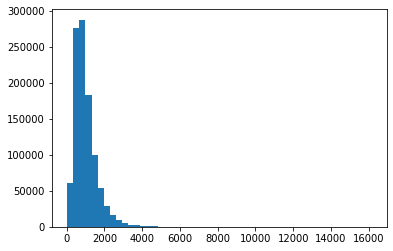

In [14]:
plt.hist(recipes_lengths, bins=50)
plt.show()

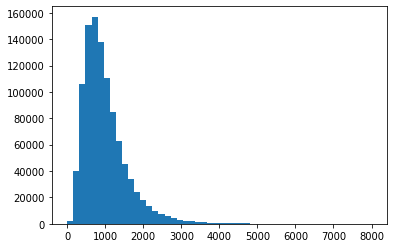

In [15]:
plt.hist(recipes_lengths, range=(0, 8000), bins=50)
plt.show()

In [16]:
# Looks like a limit of 2000 characters for the recipes will cover 80+% cases.
# We may try to train RNN with this maximum recipe length limit.
MAX_RECIPE_LENGTH = 1500

In [17]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

In [19]:
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of etiminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  1029720
Dataset size AFTER filtering:  870625
Number of etiminated recipes:  159095


In [20]:
dataset_filtered = dataset_filtered[:200000]

In [21]:
with open('../recipe1M_layers/dataset_short.json', 'w') as f:
    json.dump(dataset_filtered, f)

In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device, True)
import matplotlib.pyplot as plt
import numpy as np
import time
import pathlib
import os
import json

print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Tensorflow version: 2.4.1
Keras version: 2.4.0


In [22]:
with open('../recipe1M_layers/dataset_short.json', 'r') as f:
    dataset_filtered = json.load(f)

In [3]:
# dataset_filtered = dataset_filtered[:100000]

In [23]:
# Looks like a limit of 2000 characters for the recipes will cover 80+% cases.
# We may try to train RNN with this maximum recipe length limit.
MAX_RECIPE_LENGTH = 1500

In [24]:
TOTAL_RECIPES_NUM = len(dataset_filtered)

print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)

MAX_RECIPE_LENGTH:  1500
TOTAL_RECIPES_NUM:  200000


In [25]:
# Indicator of the end of the recipe.
STOP_SIGN = '␣'

In [26]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

In [27]:
# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

In [28]:
tokenizer.fit_on_texts(dataset_filtered)

In [29]:
# tokenizer.get_config()

In [30]:
# Adding +1 to take into account a special unassigned 0 index.
# @see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  105


In [31]:
print(tokenizer.index_word[5])
print(tokenizer.index_word[20])

t
.


In [32]:
tokenizer.word_index['r']

8

In [33]:
# For demo application we need to have an array of characters as vocabulary.
js_vocabulary = tokenizer.sequences_to_texts([[word_index] for word_index in range(VOCABULARY_SIZE)])
# print([char for char in js_vocabulary])

In [34]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    recipe_stringified = recipe_stringified.replace('   ', '_').replace(' ', '').replace('_', ' ')
#     print(recipe_stringified)
    return recipe_stringified

In [35]:
# Test proper conversion from text to indices.
# This is needed for debugging a demo app.
tokenized = tokenizer.texts_to_sequences(['📗 yes'])
# print(tokenized)
detokenized = tokenizer.sequences_to_texts(tokenized)
# print(detokenized)
print(recipe_sequence_to_string(tokenized[0]))

📗 yes


In [36]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

In [37]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure that all recipes will have at least 1 stops
    # sign at the end, since each sequence will be shifted and truncated afterwards (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [38]:
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [39]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (1501,), types: tf.int32>


In [40]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

In [41]:
dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset shapes: ((1500,), (1500,)), types: (tf.int32, tf.int32)>


In [42]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  200000
MAX_RECIPE_LENGTH:  1500
VOCABULARY_SIZE:  105


In [43]:
# Batch size.
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000

In [44]:
EPOCHS_DELTA = 1

In [45]:
dataset_train = dataset_targeted \
  .shuffle(SHUFFLE_BUFFER_SIZE) \
  .batch(BATCH_SIZE, drop_remainder=True) \
  .repeat(EPOCHS_DELTA)

print(dataset_train)

<RepeatDataset shapes: ((64, 1500), (64, 1500)), types: (tf.int32, tf.int32)>


In [46]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[ 47   1  32 ... 103 103 103]
 [ 47   1  56 ... 103 103 103]
 [ 47   1  33 ... 103 103 103]
 ...
 [ 47   1  33 ... 103 103 103]
 [ 47   1  52 ... 103 103 103]
 [ 47   1  43 ... 103 103 103]], shape=(64, 1500), dtype=int32)

1st batch: target_text: tf.Tensor(
[[  1  32  14 ... 103 103 103]
 [  1  56   3 ... 103 103 103]
 [  1  33   8 ... 103 103 103]
 ...
 [  1  33  16 ... 103 103 103]
 [  1  52   4 ... 103 103 103]
 [  1  43   4 ... 103 103 103]], shape=(64, 1500), dtype=int32)


In [47]:
# Length of the vocabulary in chars.
vocab_size = VOCABULARY_SIZE

# The embedding dimension.
embedding_dim = 256

# Number of RNN units.
rnn_units = 1024

STEPS_PER_EPOCH = TOTAL_RECIPES_NUM // BATCH_SIZE#1500

In [48]:
def build_model_1(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        input_length=MAX_RECIPE_LENGTH,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, MAX_RECIPE_LENGTH]
    ))

    model.add(tf.keras.layers.LSTM(
        batch_input_shape=[batch_size, MAX_RECIPE_LENGTH, embedding_dim],
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

In [49]:
model_1 = build_model_1(vocab_size, embedding_dim, rnn_units, BATCH_SIZE)

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, 1500, 256)           26880     
_________________________________________________________________
lstm (LSTM)                  (64, 1500, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, 1500, 105)           107625    
Total params: 5,381,481
Trainable params: 5,381,481
Non-trainable params: 0
_________________________________________________________________


In [56]:
for input_text, target_text in dataset_train.take(1):
    print(target_text)

tf.Tensor(
[[  1  32  15 ... 103 103 103]
 [  1  33  16 ... 103 103 103]
 [  1  65   2 ... 103 103 103]
 ...
 [  1  39   4 ... 103 103 103]
 [  1  43   3 ... 103 103 103]
 [  1  73   2 ... 103 103 103]], shape=(64, 1500), dtype=int32)


In [34]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model_1(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 1500, 105) # (batch_size, sequence_length, vocab_size)


In [35]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 1500, 105)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 1500)
scalar_loss:       4.6533303


In [37]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [50]:
# Directory where the checkpoints will be saved.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [51]:
import zipfile

def download_latest_checkpoint(zip_only=True):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    latest_checkpoint_zip_name = latest_checkpoint_name + '.zip'
    
    print('latest_checkpoint_path: ', latest_checkpoint_path)
    print('latest_checkpoint_name: ', latest_checkpoint_name)
    print('---\n')

    print('Checkpoint files:')
    with zipfile.ZipFile(latest_checkpoint_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(checkpoint_dir):
            for filename in filenames:
                if filename.startswith(latest_checkpoint_name):
                        print('  - ' + filename)
                        file_path = os.path.join(folder_name, filename)
                        zip_obj.write(file_path, os.path.basename(file_path))
    print('---\n')
    print('Zipped to: ', latest_checkpoint_zip_name)

    if not zip_only:
        files.download(latest_checkpoint_zip_name)

In [52]:
def model_weights_from_latest_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Using model as is.')
        return model

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    return model

In [59]:
def initial_epoch_from_latest_checkpoint():
    print(tf.train.latest_checkpoint(checkpoint_dir))
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Starting from epoch #0')
        return 0

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('latest_checkpoint_name: ', latest_checkpoint_name)

    latest_checkpoint_num = latest_checkpoint_name.split('_')[-1]
    print('latest_checkpoint_num: ', latest_checkpoint_num)

    return int(latest_checkpoint_num)

In [54]:
def unzip_checkpoint(checkpoint_zip_path):
    if not os.path.exists(checkpoint_zip_path):
        print('Cannot find a specified file')
        return

    os.makedirs(checkpoint_dir, exist_ok=True)
    with zipfile.ZipFile(checkpoint_zip_path, 'r') as zip_obj:
        zip_obj.extractall(checkpoint_dir)

    %ls -la ./tmp/checkpoints

In [43]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=2,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [44]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [60]:
INITIAL_EPOCH  = initial_epoch_from_latest_checkpoint()
# EPOCHS_DELTA = 10
EPOCHS = INITIAL_EPOCH + EPOCHS_DELTA
STEPS_PER_EPOCH = TOTAL_RECIPES_NUM//BATCH_SIZE#1500

print('\n')
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('EPOCHS_DELTA:    ', EPOCHS_DELTA)
print('EPOCHS:          ', EPOCHS)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

None
Latest checkpoint was not found. Starting from epoch #0


INITIAL_EPOCH:    0
EPOCHS_DELTA:     1
EPOCHS:           1
STEPS_PER_EPOCH:  3125


In [58]:
history_1 = {} if not history_1 else history_1
print(history_1)

{}


In [59]:
history_1[INITIAL_EPOCH] = model_1.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

model_name = 'recipe_generation_rnn_raw_' + str(INITIAL_EPOCH) + '.h5'
model_1.save(model_name, save_format='h5')

download_latest_checkpoint(zip_only=True)

3125/3125 [==============================] - 2291s 733ms/step - loss: 0.4502
latest_checkpoint_path:  tmp/checkpoints/ckpt_1
latest_checkpoint_name:  ckpt_1
---

Checkpoint files:
  - ckpt_1.index
  - ckpt_1.data-00000-of-00001
---

Zipped to:  ckpt_1.zip


In [60]:
print(history_1)

{0: <tensorflow.python.keras.callbacks.History object at 0x7fac68f84d60>}


In [61]:
# Download zipped latest checkpoint to local drive.
# download_latest_checkpoint(zip_only=True)

In [64]:
# model_name = 'recipe_generation_rnn_raw_' + str(INITIAL_EPOCH) + '.h5'
# model_1.save(model_name, save_format='h5')

In [65]:
def render_training_history(training_history):
    if 'history' in training_history:
        loss = training_history.history['loss']
    else:
        loss = []
        for initial_epoch in training_history:
            loss += training_history[initial_epoch].history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

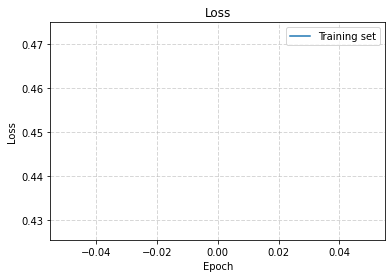

In [66]:
render_training_history(history_1)

In [67]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_1'

In [69]:
simplified_batch_size = 1

model_1_simplified = build_model_1(vocab_size, embedding_dim, rnn_units, simplified_batch_size)

model_1_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_1_simplified.build(tf.TensorShape([simplified_batch_size, None]))

In [70]:
model_1_simplified.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, 1500, 256)            26880     
_________________________________________________________________
lstm_2 (LSTM)                (1, 1500, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, 1500, 105)            107625    
Total params: 5,381,481
Trainable params: 5,381,481
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_1_simplified.input_shape

(1, 1500)

In [72]:
# num_generate
# - number of characters to generate.
#
# temperature
# - Low temperatures results in more predictable text.
# - Higher temperatures results in more surprising text.
# - Experiment to find the best setting.
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    
#     padded_start_string = STOP_WORD_TITLE + start_string
    padded_start_string = start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [73]:
def generate_combinations(model):
    recipe_length = 1000
#     try_letters = ['', '\n', 'A', 'B', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Christmass', 'The', 'Banana', 'Homemade']
    try_letters = [recipe_sequence_to_string(dataset_vectorized_padded[5]).split("📝")[0] + "📝"]
    try_temperature = [1.0, 0.8, 0.6, 0.4, 0.2]

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')


In [74]:
generate_combinations(model_1_simplified)

Attempt: "📗 Kombu Tea Grilled Chicken Thigh

🥕

• 2 Chicken thighs
• 2 tsp Kombu tea
• 1 White pepper

📝" + 1.0
-----------------------------------
📗 Kombu Tea Grilled Chicken Thigh

🥕

• 2 Chicken thighs
• 2 tsp Kombu tea
• 1 White pepper

📝

▪︎ pierce in refrigerator basil for burning.
▪︎ You may not overmometes!
▪︎ Stuff bottom of thigh will lightly bloiled.
▪︎  recipe accordingly.
▪︎ This aru awway.
▪︎ 3.
▪︎ Add hands, cloves and allapin' by sandwich mixture and add more vingis or some lemons with water whellybaki.
▪︎ top with parfaian and slice roast think (about gutch or for freezer).
▪︎ Pour or stain vigorously blend with a meal bath but flavor in the salted well in large pieces.
▪︎ Spread butter/batches in bottom of a 2 cupful pizza triangles.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

In [115]:
a = recipe_sequence_to_string(dataset_vectorized_padded[5]).split("📝")[0] + "📝"
print(a)

📗 Kombu Tea Grilled Chicken Thigh

🥕

• 2 Chicken thighs
• 2 tsp Kombu tea
• 1 White pepper

📝


In [ ]:
model_name = 'recipe_generation_rnn.h5'
model_1_simplified.save(model_name, save_format='h5')